In [1]:
import torch.nn.functional as F
import os
import json
from torchvision import datasets
import cv2
from utils.data import MultiViewTemporalSample, make_impossible_mask
import utils.data as data
import utils.sub_architectures as sub_architectures
import utils.architectures as architectures
from utils.architectures import ScoreAnomalyDetection
from utils.basic_function import draw_labels
import importlib
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader
from utils.basic_function import integrate_images
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wasserstein_distance
from scipy.special import softmax
import scipy
import ot
from utils.evaluation_metrics import compute_AP,compute_IoU



In [2]:
dataset = data.MultiViewTemporalDataset(mode = "validation", preprocess_image_options = {
            "use_mask": True,
            "equalize_hist": False,
            "crop_black": False,
            "match_histogram": True
        }, data_path="data")


In [3]:
autoencoder = sub_architectures.ConvolutionalAutoencoderV2()
state_dict = torch.load("saved_models/ConvolutionalAutoencoderV2/2022-01-09_20-42-42.pt",map_location=torch.device('cpu') )
autoencoder.load_state_dict(state_dict)
autoencoder.eval()
# autoencoder.state_dict()

ConvolutionalAutoencoderV2(
  (enc_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (dec_conv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec_conv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (dec_conv3): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
  (dropout): Dropout2d(p=0.2, inplace=False)
)

In [4]:

class IntegrateReconstructedImages(ScoreAnomalyDetection):
    def __init__(self,path):
        self.path = path
    
        homography_dict = json.load(
            open(os.path.join(path, "homographies.json"))
        )
        _photo_order = ["B05", "B04", "B03", "B02", "B01", "G01", "G02", "G03", "G04", "G05"]

        self.homographies = []

        self.path = path
        for timestep in range(0, 7):

            timestep_homographies = []
            for perspective in _photo_order:
                name = str(timestep) + "-" + perspective

                homography = homography_dict[name]

                timestep_homographies.append(homography)

            timestep_homographies = np.array(timestep_homographies)

            self.homographies.append(timestep_homographies)

        self.homographies = np.array(self.homographies)
    def integrate(self, photos, timestep):
        return integrate_images(photos[timestep], self.homographies[timestep])

In [5]:

class WassersteinAnomalyScore(ScoreAnomalyDetection):
    def __init__(self,path,sample:data.MultiViewTemporalSample,
    integrateimages:IntegrateReconstructedImages,
    square_distance = True):
        self.path = path
        self.integrateimages = integrateimages

        self.sample = sample
        self.square_distance = square_distance


    def get_score(self,reconstructed_photos):
    
        scores = []
        for t in range(7):
            int_img = self.sample.integrate(t)
            int_recon_img = self.integrateimages.integrate(reconstructed_photos, t)
            if self.square_distance:
                distance = np.square(abs(int_img - int_recon_img))
                score = cv2.GaussianBlur(np.amax(distance,axis=-1),(9,9),6)
                scores.append(score)
            else:
                distance = w_score(int_img,int_recon_img)
                score = cv2.GaussianBlur(distance,(9,9),6)
                scores.append(score)
        scores = np.array(scores)
        
        # scores = np.mean(scores,axis=0)
        return np.amax(scores,axis=0)
    # score_img = cv2.GaussianBlur(np.amax(square_img,axis = -1),(9,9),6)
    # scire_img = cv2.Sobel(np.amax(square_img,axis=-1),cv2.CV_64F,0,1,ksize=9)

In [6]:
def w_score(image,reconstruct_image):
    m,n,_ = image.shape
    wass_score = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            wass_score[i,j] = wasserstein_distance(image[i,j,:],reconstruct_image[i,j,:])

    return wass_score

In [7]:
def reconstruct_image(image, autoencoder):
   

    photos = image.photos
    reconstructed_photos = np.empty_like(photos)

    for timestep_idx, timestep in enumerate(photos):
        for view_idx, view in enumerate(timestep):
            grid_images = []
            reconstructed_view = np.empty_like(view)
            for row in range(16):
                for col in range(16):
                    grid_images.append(
                        view[
                            row * 64 : (row + 1) * 64, col * 64 : (col + 1) * 64
                        ]
                    )

            grid_images = np.array(grid_images)
            grid_images = (
                np.transpose(grid_images, (0, 3, 1, 2)).astype(np.float32) / 255
            )

            grid_images = torch.tensor(grid_images, device="cpu")
            reconstructed_grid_images = (
                autoencoder(grid_images)
                .detach().cpu()
                .numpy()
            )
            reconstructed_grid_images = np.transpose(
                (reconstructed_grid_images * 255).astype(np.int16), (0, 2, 3, 1)
            )

            i = 0
            for row in range(16):
                for col in range(16):
                    reconstructed_view[
                        row * 64 : (row + 1) * 64, col * 64 : (col + 1) * 64
                    ] = reconstructed_grid_images[i]
                    i += 1
            reconstructed_photos[timestep_idx, view_idx] = reconstructed_view
    return reconstructed_photos

In [8]:
class MSEAnomalyDetection(ScoreAnomalyDetection):
    def __init__(self,score,threshold = 0.5):
        self.sample = sample
        self.score = score
    def get_anomaly_bb(self,sample):
        mask = make_impossible_mask(self.sample)
        self.score[mask] = 0
        self.score[self.score < 0.2 *255] = 0
        
        thresh = ((self.score >= threshold) * 255).astype(np.uint8)
        contours,_= cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

        boxes = []
        for cntr in contours:
            box = np.array(cv2.boundingRect(cntr))
            boxes.append(box.tolist())
        return boxes

        

In [9]:
sample = dataset[0]
path = "/Users/mindy/百度云同步盘/StudyResearch/ComputerVision/WiSAR/data/validation/valid-2-0"
reconstructed_photos = reconstruct_image(sample, autoencoder)




In [10]:
integrateimages = IntegrateReconstructedImages(path)

TypeError: Can't instantiate abstract class IntegrateReconstructedImages with abstract method score

In [ ]:
anoscore = WassersteinAnomalyScore(path,sample,integrateimages)
score = anoscore.get_score(reconstructed_photos)
score


array([[16, 16, 14, ...,  4,  4,  4],
       [16, 16, 14, ...,  4,  4,  4],
       [15, 15, 13, ...,  4,  4,  4],
       ...,
       [17, 18, 19, ..., 24, 22, 21],
       [19, 19, 19, ..., 26, 23, 23],
       [19, 19, 19, ..., 26, 24, 24]], dtype=uint8)

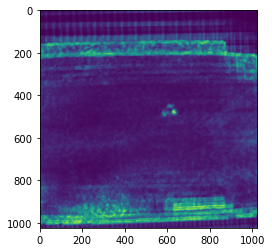

In [91]:
plt.imshow(score)

In [ ]:
box = MSEAnomalyDetection(score)
boxes = box.get_anomaly_bb(sample)
# labels[dir] = boxes
# box = MSEAnomalyDetection(score)
# box.get_anomaly_bb(dataset[0])
boxes

[[574, 476, 24, 23], [616, 465, 26, 27], [600, 444, 22, 14]]

In [130]:
def collect_labels(dataset,path,autoencoder):
    # dirs = [dir for dir in os.listdir(path) if os.path.isdir(os.path.join(path, dir))]
    # dirs.sort()
    labels = {}
             
    for sample in dataset:
        sample_name = os.path.split(sample.sample_path)[-1]
      
        sub_path = os.path.join(path, sample_name)
        reconstructed_photos = reconstruct_image(sample,autoencoder)
        integrateimages = IntegrateReconstructedImages(sub_path)
        anoscore = WassersteinAnomalyScore(sub_path,sample,integrateimages)
        score = anoscore.get_score(reconstructed_photos)
        box = MSEAnomalyDetection(score)
        boxes = box.get_anomaly_bb(sample)
        labels[sample_name] = boxes
    

        
    return labels

In [131]:
path = "/Users/mindy/百度云同步盘/StudyResearch/ComputerVision/WiSAR/data/validation"
labels = collect_labels(dataset,path,autoencoder)
labels

{'valid-2-0': [[574, 476, 24, 23], [616, 465, 26, 27], [600, 444, 22, 14]],
 'valid-2-1': [[579, 470, 27, 25], [610, 453, 29, 29]],
 'valid-1-0': [[651, 483, 12, 8], [672, 476, 11, 14], [632, 439, 30, 28]],
 'valid-1-1': [[636, 492, 2, 2], [628, 472, 27, 19], [629, 429, 22, 29]],
 'valid-1-6': [[523, 603, 1, 1],
  [603, 478, 3, 2],
  [573, 455, 28, 25],
  [594, 460, 3, 3],
  [573, 458, 3, 3]],
 'valid-2-3': [[578, 502, 5, 5], [599, 435, 28, 29], [529, 397, 18, 11]],
 'valid-2-2': [[592, 467, 3, 4], [603, 437, 29, 31], [563, 401, 2, 3]],
 'valid-1-3': [[342, 766, 2, 1],
  [307, 766, 4, 2],
  [568, 481, 24, 37],
  [596, 415, 22, 22]],
 'valid-1-4': [[545, 517, 16, 29], [600, 443, 5, 3], [581, 431, 18, 17]],
 'valid-1-5': [[504, 563, 16, 18], [549, 445, 22, 20], [554, 449, 4, 5]],
 'valid-1-2': [[587, 475, 25, 35], [627, 449, 1, 1], [603, 422, 22, 26]]}

In [119]:
def write_bb(file: Path, bbs: Dict[str, List[BoundingBox]]) -> None:
    """ Write bounding boxes to json file.
    """
    with open(file, "w") as f:
        json.dump(bbs, f)

In [133]:
write_bb("//Users/mindy/百度云同步盘/StudyResearch/ComputerVision/WiSAR/data/validation/predicted_labels.json", labels)

In [134]:
def read_bb(file: Path) -> Dict[str, List[BoundingBox]]:
    """ Read bounding boxes from json file.
    """
    with open(file) as f:
        js = json.load(f)
    return js

In [135]:
valid_labels = read_bb("//Users/mindy/百度云同步盘/StudyResearch/ComputerVision/WiSAR/data/validation/labels.json")

In [140]:
compute_AP(dict(sorted(valid_labels.items())), dict(sorted(labels.items())))

0.09523809523809523

In [61]:
C1= scipy.spatial.distance.cdist(np.amax(int_original,axis=-1),np.amax(int_original,axis=-1))
C2= scipy.spatial.distance.cdist(np.amax(int_reconstructed,axis=-1),np.amax(int_reconstructed,axis=-1))
p = ot.unif(1024)
q = ot.unif(1024)

w,log = ot.partial.entropic_partial_gromov_wasserstein(C1,C2,p,q,10,m=1,log=True)

/usr/local/Caskroom/miniconda/base/envs/torch/lib/python3.9/site-packages/ot/partial.py:829: RuntimeWarning: divide by zero encountered in double_scalars
  np.multiply(K, m / np.sum(K), out=K)
/usr/local/Caskroom/miniconda/base/envs/torch/lib/python3.9/site-packages/ot/partial.py:829: RuntimeWarning: invalid value encountered in multiply
  np.multiply(K, m / np.sum(K), out=K)


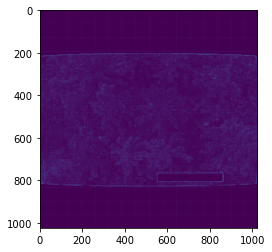

In [ ]:
wass_score = WassersteinAnomalyScore(ori_image,recon_image)
plt.imshow(wass_score.get_score(reconstructed_photos))

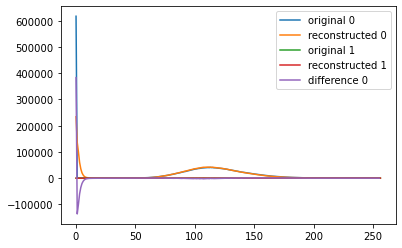

In [ ]:
hist_original = np.histogram(int_original.ravel(), bins=256)
hist_reconstructed = np.histogram(int_reconstructed.ravel(), bins=256)
plt.plot(hist_original[0], label="original 0")
plt.plot(hist_reconstructed[0], label="reconstructed 0")
plt.plot(hist_original[1], label="original 1")
plt.plot(hist_reconstructed[1], label="reconstructed 1")
plt.plot(hist_original[0] - hist_reconstructed[0], label="difference ")
plt.legend()


In [42]:
reconstructed_photos = reconstruct_image(dataset[0], autoencoder)

integrateimages = IntegrateReconstructedImages('/Users/mindy/百度云同步盘/StudyResearch/ComputerVision/WiSAR/data/validation/valid-2-0')
int_reconstructed = integrateimages.integrate(reconstructed_photos,0)

int_original = dataset[0].integrate(0)
diff = abs(int_original - int_reconstructed)
diff_gray = abs(cv2.cvtColor(int_original,cv2.COLOR_BGR2GRAY) - cv2.cvtColor(int_reconstructed,cv2.COLOR_BGR2GRAY))
diff.shape
ori_image = dataset[0].photos[0][0]
recon_image = reconstructed_photos[0][0]
diff_image = abs(ori_image - recon_image)
m_image = np.square(diff_image)
mse_image = np.square(diff)
score_img = cv2.GaussianBlur(np.amax(mse_image,axis = -1),(9,9),6)



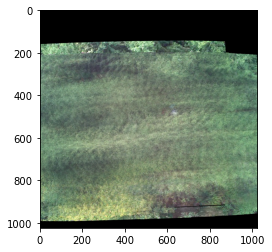

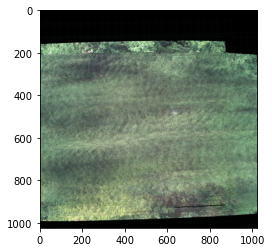

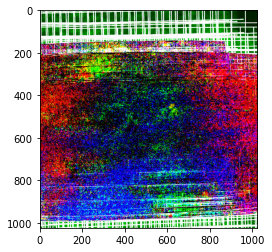

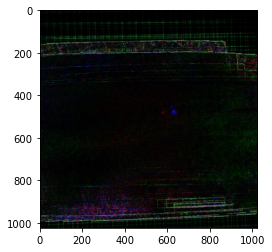

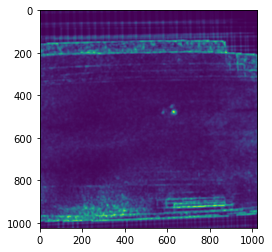

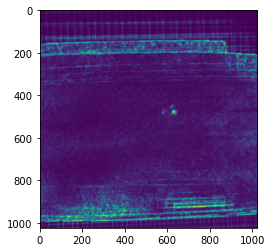

In [98]:
plt.imshow(dataset[0].integrate(0))
plt.show()
plt.imshow(int_reconstructed)
plt.show()

plt.imshow(diff)
plt.show()
plt.imshow(mse_image)
plt.show()
plt.imshow(cv2.GaussianBlur(np.amax(mse_image,axis = -1),(9,9),6))
plt.show()
plt.imshow(cv2.GaussianBlur(np.amax(mse_image,axis = -1),(9,9),0))
plt.show()

In [21]:
score_g = []
score_s = []
for i in range(7):
    int_ori_img = dataset[0].integrate(i)
    int_recon_img = integrateimages.integrate(reconstructed_photos,i)
    square_img = np.square(abs(int_ori_img - int_recon_img))
    score_img = cv2.GaussianBlur(np.amax(square_img,axis = -1),(9,9),6)
    scire_img = cv2.Sobel(np.amax(square_img,axis=-1),cv2.CV_64F,0,1,ksize=9)
    score_g.append(score_img)
    score_s.append(scire_img)

score_g = np.array(score_g)
score_s = np.array(score_s)
# score_g = np.amax(score_g,axis=-1)
score_g.shape


(7, 1024, 1024)

In [56]:
path = "/Users/mindy/百度云同步盘/StudyResearch/ComputerVision/WiSAR/data/validation/valid-2-0"
scores = WassersteinAnomalyScore(path,dataset[0],integrateimages, square_distance = True)
score_mean = scores.get_score(reconstructed_photos)



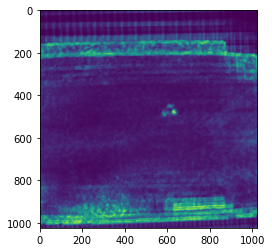

In [57]:
# path = '/Users/mindy/百度云同步盘/StudyResearch/ComputerVision/WiSAR/data/validation/valid-2-0'
# anoscore = WassersteinAnomalyScore(dataset[0], integrateimages,square_distance=True)
# score = anoscore.get_score(reconstructed_photos)
score_mean.shape
plt.imshow(score_mean)

In [22]:
mask = make_impossible_mask(dataset[0])
# mask = ~ np.amin(score_g, axis=0).astype(bool)
score = np.amax(score_g, axis=0)
masked_score = np.amax(score_g, axis=0)
# masked_score1 = mask(masked_score)
masked_score[mask] = 0
score_mean[mask] = 0
score_mean[score_mean < 0.2 * 255] = 0
s_g=masked_score
s_g[s_g<0.2*255] = 0
# smg = np.array(score*255,dtype=np.uint8)

# thresh = cv2.adaptiveThreshold(smg,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
gray=cv2.cvtColor(masked_score,cv2.COLOR_GRAY2BGR)

gray.shape


(1024, 1024, 3)

In [23]:
def mask(score):
    m,n = score.shape
    score =score
    for i in range(m):
        if i>800 or i<250:
            score[i,:] = 0
    return score

mscore = mask(score)

In [106]:
threshold=0.5
thresh = ((score >= threshold) * 255).astype(np.uint8)
contours,_= cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# cv2.imshow('TREE',dataset[0].photos[0][0])
# cv2.waitKey(0)
# cv2.destroyAllWindows()
boxes = []
for cntr in contours:
    box = np.array(cv2.boundingRect(cntr))
    boxes.append(box)
boxes

[array([574, 476,  24,  23]),
 array([616, 465,  26,  27]),
 array([600, 444,  22,  14])]

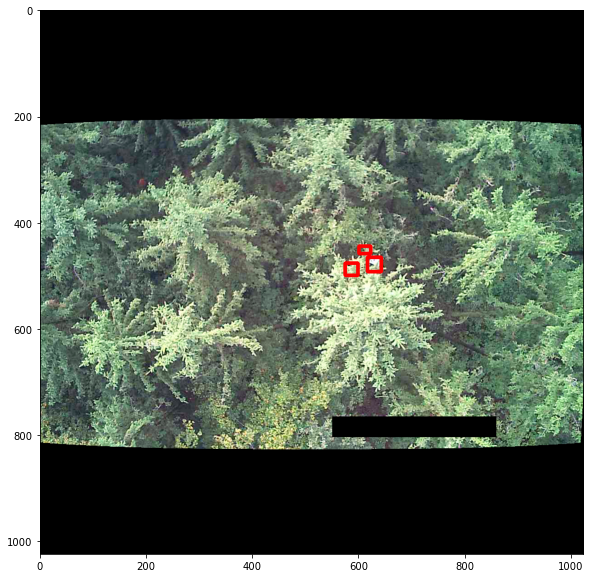

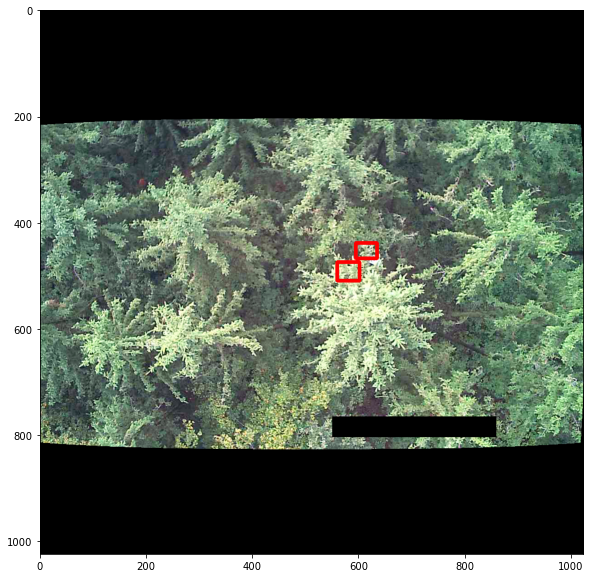

In [107]:
sample = dataset[0]
sample.draw_labels(np.array([boxes[0],boxes[1],boxes[2]]))

sample.draw_labels()

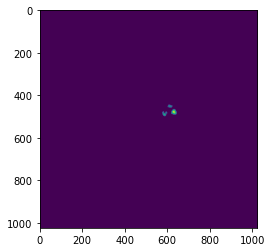

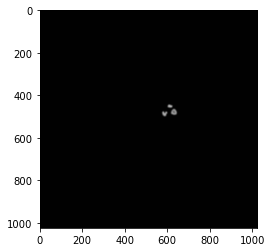

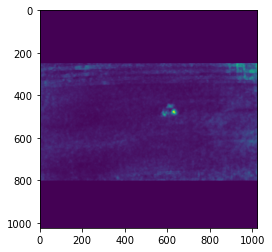

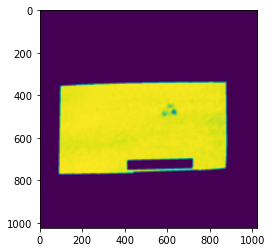

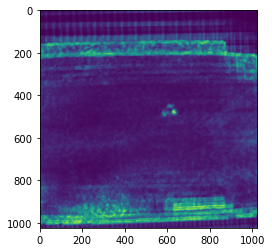

In [248]:

plt.imshow(masked_score)
plt.show()
plt.imshow(1-gray)
plt.show()
plt.imshow(cv2.GaussianBlur(1-gray,(9,9),6))
plt.show()
plt.imshow(mscore)
plt.show()
plt.imshow(gscore)
plt.show()

plt.imshow(score)
plt.show()
